In [467]:
# Import necessary libraries
import pandas as pd
import numpy as np

# NLP libraries
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

# ML libraries
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import joblib

# Neural Networks libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, Dropout, Bidirectional,Flatten
from keras.models import Sequential

# Visualization librations
import matplotlib.pyplot as plt
import seaborn as sns

# Word Cloud libraries
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import requests

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [468]:
# lemmatizer
lm = WordNetLemmatizer()

# Checks if given word contains a special character
def contains_special(word):
    for char in word:
        if char.isnumeric() or (not char.isalnum()):
            return True
    return False

# process sentences
def process_sentences(sentence):
    # tokenize, lemmatize, and remove special characters
    processed = [lm.lemmatize(word.lower()) for word in nltk.word_tokenize(sentence)
          # make sure no strings that contain only numeric characters
          if not contains_special(word)]
    return ' '.join(processed)

In [469]:
# get data
df = pd.read_csv('tweets.csv')
# drop duplicates
df.drop_duplicates(inplace =True)
X = df['text']
y = df['target']

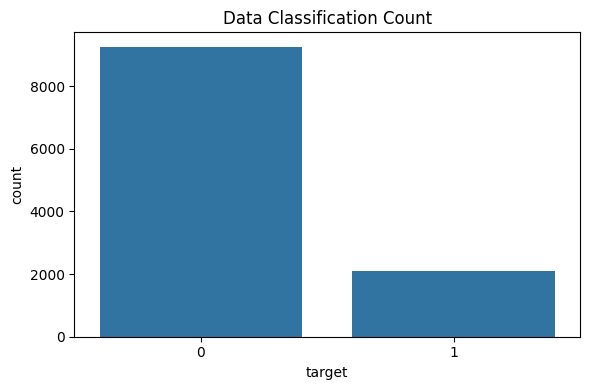

In [470]:
y.value_counts()

#Plot counts
plt.figure(figsize=(6,4))
sns.countplot(data = df, x = 'target')
plt.title('Data Classification Count')
plt.tight_layout()
plt.savefig("Data Classification Count")

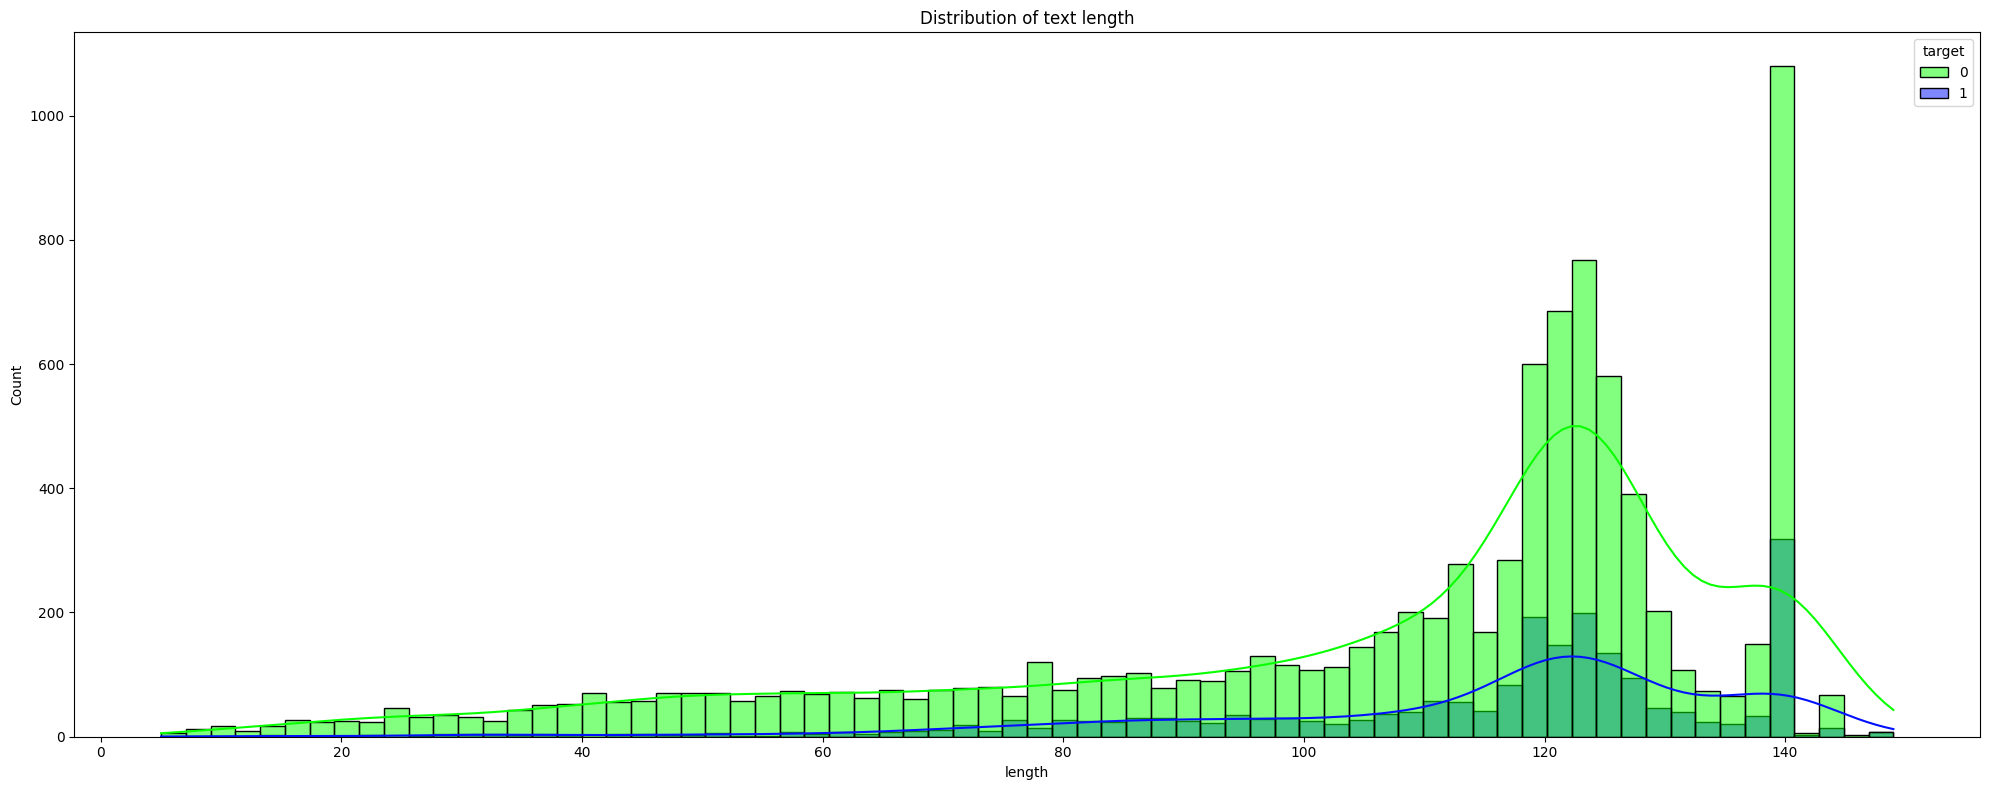

In [471]:
#Histogram of text length
df['length'] = df['text'].apply(len)

plt.figure(figsize=(20,8))
sns.histplot(data=df, x='length', hue='target', palette='hsv', kde=True, bins=70)
plt.title('Distribution of text length')
plt.tight_layout()
plt.show()


In [472]:
# resampling methods
def resampling(df):
  # filter df by class
  df_non_disaster = df[df['target'] == 0]
  df_disaster = df[df['target'] == 1]
  # get total count for each class
  total_non_disaster, total_disaster = df['target'].value_counts()

  undersampling = pd.concat([df_non_disaster.sample(total_disaster), df_disaster])
  oversampling = pd.concat([df_non_disaster, df_disaster.sample(total_non_disaster, replace=True)])
  return undersampling, oversampling

# get BoW features
def get_bow(X, df_type):
  # pre-process text
  X = X.apply(process_sentences)
  # vectorize
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(X)
  vocabulary = vectorizer.vocabulary_
  joblib.dump(vectorizer, f"vectorizer_{df_type}.pk1")
  return X, vocabulary

# get data based the desired text representation and dataset type
def get_data(representation, df_type, embedding_size=200):
  df = pd.read_csv('tweets.csv')
  # drop duplicates
  df.drop_duplicates(inplace =True)
  if df_type == 'original':
    # original data
    X = df['text']
    y = df['target']
  else:
    # apply resampling methods on data
    undersampling,oversampling = resampling(df)
    if df_type == 'undersampling':
      # undersampling
      X = undersampling['text']
      y = undersampling['target']
    elif df_type == 'oversampling':
      # oversampling
      X = oversampling['text']
      y = oversampling['target']

  # convert text data into features for model input
  if representation == get_bow:
    X, vocabulary = representation(X, df_type)
    return X,y,vocabulary
  elif representation == get_word2vec:
    X, word2vec, vocab_size = representation(X, embedding_size, df_type)
    return X,y,word2vec,vocab_size

In [473]:
# get data
X, y, vocabulary = get_data(get_bow, 'original')
X_undersampling, y_undersampling, vocab_undersampling = get_data(get_bow, 'undersampling')
X_oversampling, y_oversampling, vocab_oversampling = get_data(get_bow, 'oversampling')

# double check vocab size
print('Vocab size of original dataset: ' + str(len(vocabulary)))
print('Vocab size of undersampling dataset: ' + str(len(vocab_undersampling)))
print('Vocab size of oversampling dataset: ' + str(len(vocab_oversampling)))

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.30, random_state=1)

X_train_undersampling, X_test_undersampling, y_train_undersampling, y_test_undersampling = \
train_test_split(X_undersampling.toarray(), y_undersampling, test_size=0.30, random_state=1)

X_train_oversampling, X_test_oversampling, y_train_oversampling, y_test_oversampling = \
train_test_split(X_oversampling.toarray(), y_oversampling, test_size=0.30, random_state=1)

Vocab size of original dataset: 16985
Vocab size of undersampling dataset: 9213
Vocab size of oversampling dataset: 16978


In [474]:
# Helper methods for plots


# Plot count graphs for train and test sets
def plot_train_test_count(y_train, y_test, df_type):
  plt.figure(figsize=(12, 4))

  train_class_counts = pd.Series(y_train).value_counts().sort_index()
  test_class_counts = pd.Series(y_test).value_counts().sort_index()

  plt.subplot(1, 2, 1)
  sns.barplot(x=train_class_counts.index, y=train_class_counts.values)
  plt.title('Training Data Class Distribution: ' + df_type)
  plt.xlabel('Class')
  plt.ylabel('Count')

  plt.subplot(1, 2, 2)
  sns.barplot(x=test_class_counts.index, y=test_class_counts.values, color='#C0392B')
  plt.title('Test Data Class Distribution for ' + df_type)
  plt.xlabel('Class')
  plt.ylabel('Count')

  plt.tight_layout()
  plt.savefig("Separated Data Classification Count for " + df_type)

# Plot confusion matrices for model performance
def confusion(y_test, ypred, model):
  cf_matrix = confusion_matrix(y_test, ypred)
  categories = ['Non-Disaster', 'Disaster']
  cf_normalized = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize= (6,4))
  sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='Blues',
              xticklabels=categories, yticklabels=categories)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(model + ' Confusion Matrix')
  plt.savefig(model + " Confusion Matrix")

  plt.figure(figsize= (6,4))
  sns.heatmap(cf_normalized, annot=True, fmt='.2f', cmap='Reds',
              xticklabels=categories, yticklabels=categories)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(model + ' Confusion Matrix (Normalized)')
  plt.savefig(f"{model} Confusion Matrix Normalized")

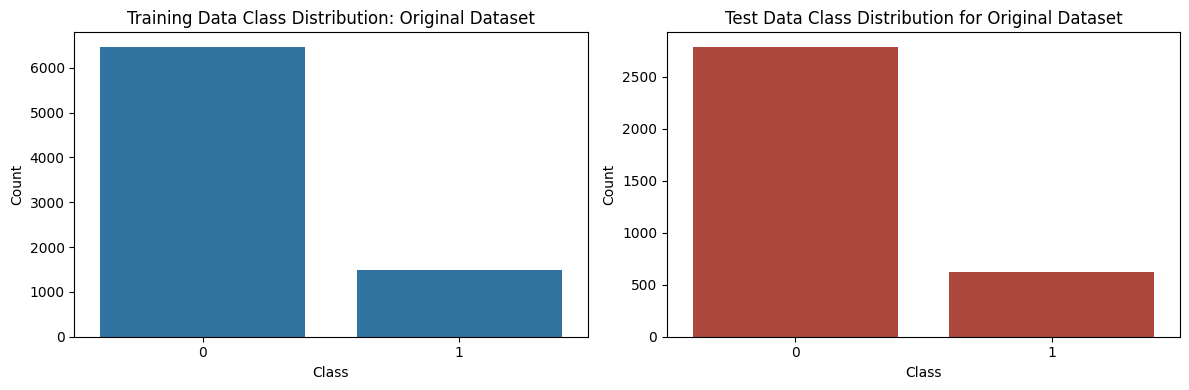

In [475]:
plot_train_test_count(y_train, y_test, "Original Dataset")

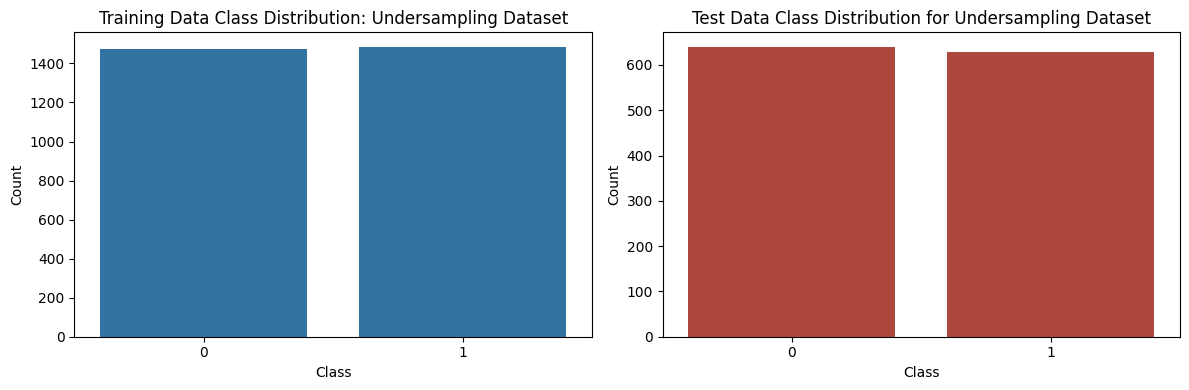

In [476]:
plot_train_test_count(y_train_undersampling, y_test_undersampling, "Undersampling Dataset")

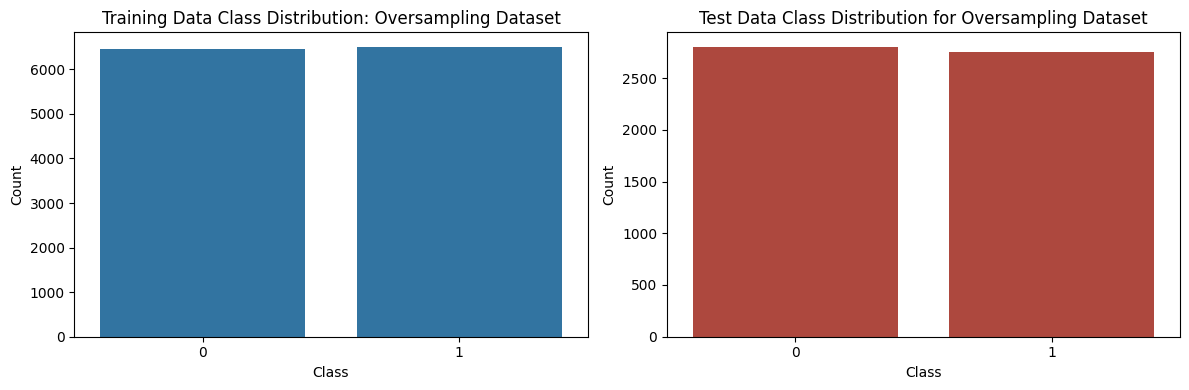

In [477]:
plot_train_test_count(y_train_oversampling, y_test_oversampling, "Oversampling Dataset")

In [478]:
# Naive Bayes
def naive_bayes(X_train, X_test, y_train, y_test, df_type):
    print('Naive Bayes: ' + df_type + '\n')
    # increased max iter to prevent early time out
    clf = MultinomialNB().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test,y_pred))

    # save model
    joblib.dump(clf, f"naive_bayes_model_{df_type}.pk1")

    return y_pred

Naive Bayes: Original Dataset

accuracy: 0.8751099384344767
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2788
           1       0.67      0.62      0.64       623

    accuracy                           0.88      3411
   macro avg       0.79      0.78      0.78      3411
weighted avg       0.87      0.88      0.87      3411



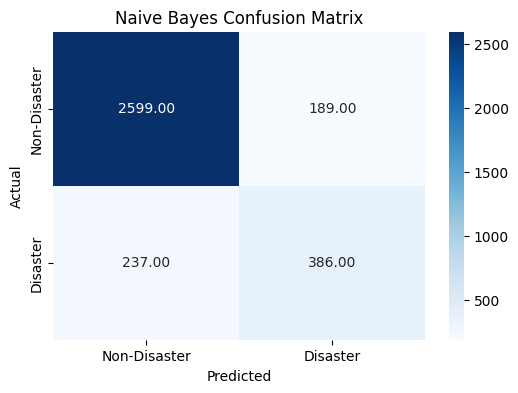

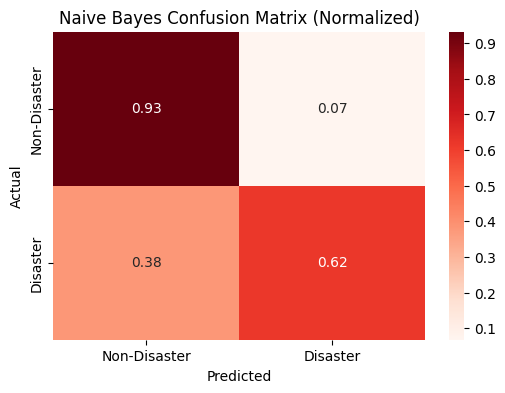

In [479]:
# Naive Bayes predictions and confusion matrices with original dataset
ypred_nb = naive_bayes(X_train, X_test, y_train, y_test, 'Original Dataset')
confusion(y_test, ypred_nb, 'Naive Bayes')

Naive Bayes: Undersampling Dataset

accuracy: 0.8148148148148148
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       640
           1       0.79      0.86      0.82       629

    accuracy                           0.81      1269
   macro avg       0.82      0.82      0.81      1269
weighted avg       0.82      0.81      0.81      1269



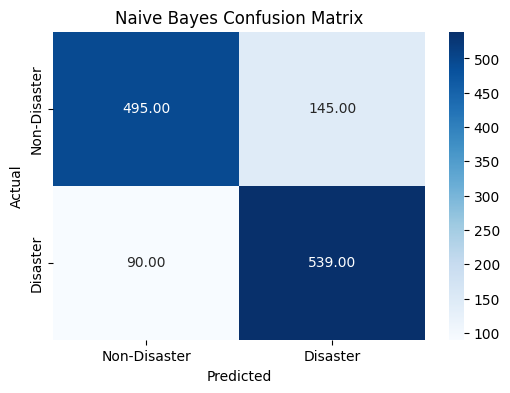

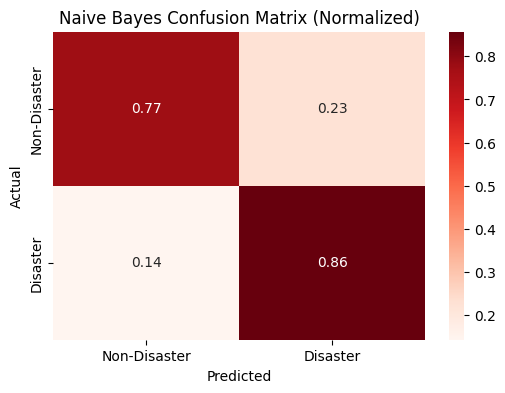

In [480]:
# Naive Bayes predictions and confusion matrices with undersampling dataset
ypred_nb_undersampling = naive_bayes(X_train_undersampling, X_test_undersampling, \
                                     y_train_undersampling, y_test_undersampling, \
                                     'Undersampling Dataset')
confusion(y_test_undersampling, ypred_nb_undersampling, 'Naive Bayes')

Naive Bayes: Oversampling Dataset

accuracy: 0.8876485415916456
              precision    recall  f1-score   support

           0       0.92      0.86      0.88      2802
           1       0.86      0.92      0.89      2752

    accuracy                           0.89      5554
   macro avg       0.89      0.89      0.89      5554
weighted avg       0.89      0.89      0.89      5554



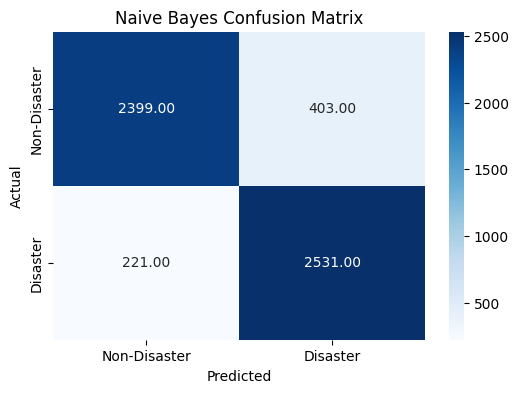

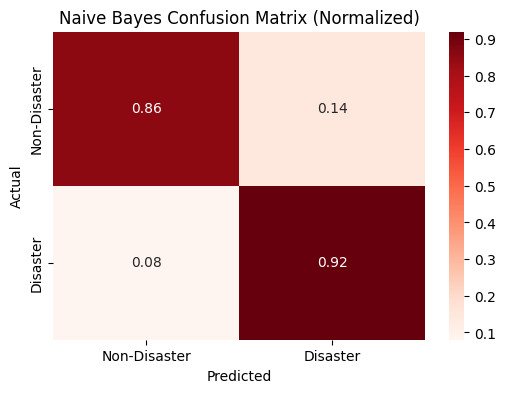

In [481]:
# Naive Bayes predictions and confusion matrices with oversampling dataset
ypred_nb_oversampling = naive_bayes(X_train_oversampling, X_test_oversampling, \
                                     y_train_oversampling, y_test_oversampling, \
                                     'Oversampling Dataset')
confusion(y_test_oversampling, ypred_nb_oversampling, 'Naive Bayes')

In [482]:
# Logistic Regression
def logistic_regression(X_train, X_test, y_train, y_test, df_type):
    print('Logistic Regression: ' + df_type + '\n')
    scaler = StandardScaler()
    # scale data to reduce ranges
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # increased max iter to prevent early time out
    clf = LogisticRegression(max_iter = 500).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test,y_pred))
    # save model
    joblib.dump(clf, f"logistic_regression_model_{df_type}.pk1")
    return y_pred

Logistic Regression: Original Dataset

accuracy: 0.8727645851656406
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2788
           1       0.68      0.58      0.62       623

    accuracy                           0.87      3411
   macro avg       0.79      0.76      0.77      3411
weighted avg       0.87      0.87      0.87      3411



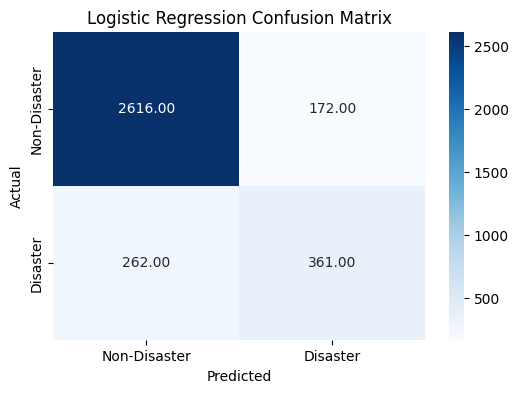

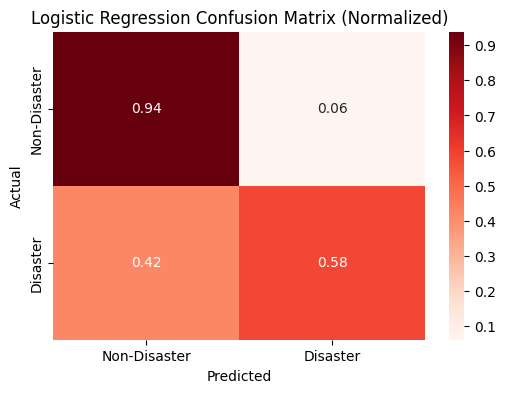

In [483]:
# Logistic regression predictions and confusion matrices with original dataset
ypred_lr = logistic_regression(X_train, X_test, y_train, y_test, 'Original Dataset')
confusion(y_test, ypred_lr, 'Logistic Regression')

Logistic Regression: Undersampling Dataset



accuracy: 0.7919621749408984
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       640
           1       0.77      0.82      0.80       629

    accuracy                           0.79      1269
   macro avg       0.79      0.79      0.79      1269
weighted avg       0.79      0.79      0.79      1269



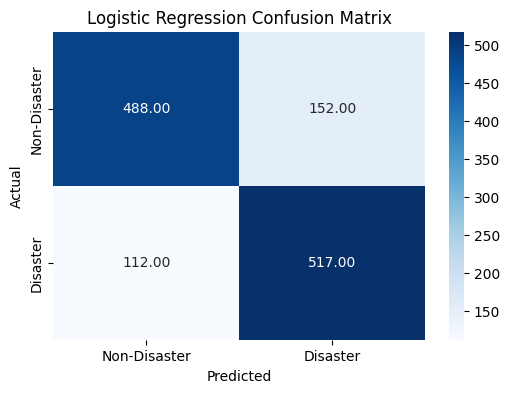

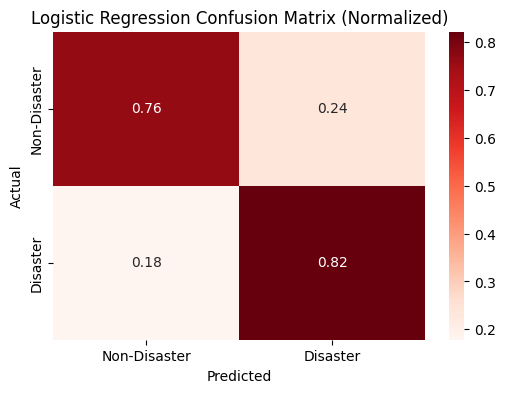

In [484]:
# Logistic regression predictions and confusion matrices with undersampling dataset
ypred_lr_undersampling = logistic_regression(X_train_undersampling, X_test_undersampling, \
                                     y_train_undersampling, y_test_undersampling, \
                                     'Undersampling Dataset')
confusion(y_test_undersampling, ypred_lr_undersampling, 'Logistic Regression')

Logistic Regression: Oversampling Dataset

accuracy: 0.9411235145840835
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2802
           1       0.90      0.99      0.94      2752

    accuracy                           0.94      5554
   macro avg       0.94      0.94      0.94      5554
weighted avg       0.95      0.94      0.94      5554



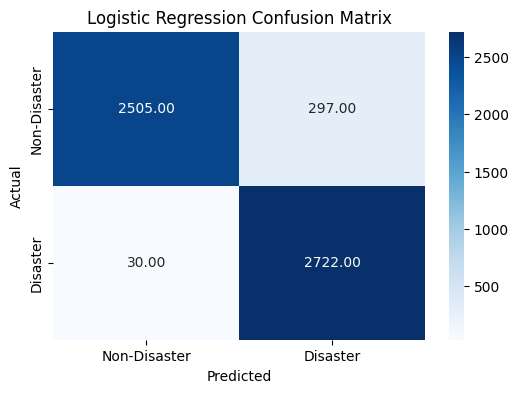

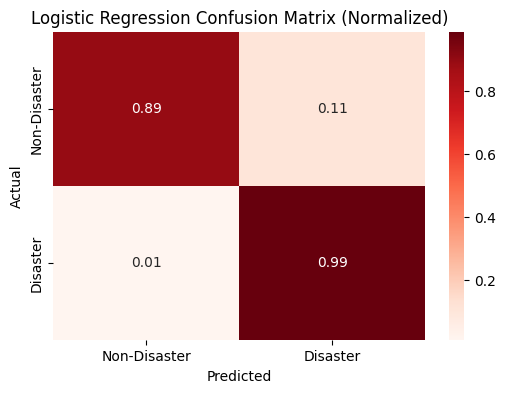

In [485]:
# Logistic regression predictions and confusion matrices with oversampling dataset
ypred_lr_oversampling = logistic_regression(X_train_oversampling, X_test_oversampling, \
                                     y_train_oversampling, y_test_oversampling, \
                                     'Oversampling Dataset')
confusion(y_test_oversampling, ypred_lr_oversampling, 'Logistic Regression')

In [486]:
from gensim.models import Word2Vec

# convert data to word embeddings
def get_word2vec(X, size, df_type):
  # text pre-processing
  X = X.apply(process_sentences)
  # process data for Gensim's Word2Vec
  X = X.apply(nltk.word_tokenize)
  # word2vec skip-gram architecture
  word2vec = Word2Vec(sentences=X, vector_size=size, window=5, min_count=1,sg=1)
  vocab_size = len(word2vec.wv.index_to_key)

  joblib.dump(word2vec, f"word2vec_vectorizer_{df_type}.pk1")
  return X, word2vec, vocab_size

# get a mapping of word -> embedding, word_index -> embedding
def map_embeddings(model, tokenizer):
    # all vocab
    vocab = list(model.wv.index_to_key)
    # word to word index map
    word_index = tokenizer.word_index
    # word to embedding map
    word_embed = {}
    # word index to embedding map
    index_embed = {}

    for w in vocab:
        # get current word's embedding
        e = model.wv[w]
        # set embedding for current word
        word_embed[w] = e
        # set embedding for current word index
        curr_index = word_index[w]
        index_embed[curr_index] = e
    return word_embed, index_embed

# pre-padding data to fixed length token for NN input
def pre_padding(encoded, seq_length):
    X = pad_sequences(encoded, maxlen = seq_length)
    return X

# convert data into 3D matrix (total rows, max sequence length, embedding size) for LSTM
def reshape_data(X, index_embed):
  reshaped = []
  for seq in X:
    # get embeddings for each word index in sequence
    seq_embed = [index_embed[index] for index in seq]
    reshaped.append(seq_embed)
  # convert to numpy array
  return np.array(reshaped)

# Get input for neural network
def get_nn_input(X, word2vec, embedding_size):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(X)
  # embeddings
  word_embed, index_embed = map_embeddings(word2vec, tokenizer)
  # set embeddings for zero index
  index_embed[0] = np.zeros((embedding_size,))
  word_embed[''] = np.zeros((embedding_size,))
  vocab_size = len(word_embed.keys())
  # encode data into word indexes
  encoded_data = tokenizer.texts_to_sequences(X)
  # max sequence length
  max_sequence_length = np.max([len(seq) for seq in encoded_data])
  # prepadding on data
  pre_padded_X = pre_padding(encoded_data, max_sequence_length)
  X = reshape_data(pre_padded_X, index_embed)
  return X,index_embed, max_sequence_length

# def data_generator(X, y, num_sequences, index_embed, model) -> (list,list):
def data_generator(X, y, num_sequences, index_embed, model):
    i = 0
    while i < len(X):
        # end range of data for current batch
        end_index = i + num_sequences
        # reached end of our dataset
        if end_index >= len(X) - 1:
            i = 0
            end_index = i + num_sequences

        if model == "ffnn":
          # we need to flatten our inputs for a feedforward network
          inputs = [input.flatten() for input in X[i:end_index]]
        else:
          inputs = [val for val in X[i:end_index]]

        outputs = [val for val in y[i:end_index]]
        yield np.array(inputs), np.array(outputs)
        i += num_sequences



In [487]:
# get data
embedding_size = 200
X, y, word2vec, vocab_size = get_data(get_word2vec, 'original',embedding_size)

X_undersampling, y_undersampling, word2vec_undersampling, vocab_size_undersampling = \
get_data(get_word2vec, 'undersampling',embedding_size)

X_oversampling, y_oversampling, word2vec_oversampling, vocab_size_oversampling = \
get_data(get_word2vec, 'oversampling',embedding_size)
# double check vocab size
print('Vocab size of original dataset: ' + str(vocab_size))
print('Vocab size of undersampling dataset: ' + str(vocab_size_undersampling))
print('Vocab size of oversampling dataset: ' + str(vocab_size_oversampling))

# pre-process data for NN input
# FFNN input for original data, index to embeddings map, max sequence length
X, index_embed, msq = get_nn_input(X, word2vec, embedding_size)
print(X.shape)

# FFNN input for undersampling data, index to embeddings map, max sequence length
X_undersampling, index_embed_undersampling, msq_undersampling = \
get_nn_input(X_undersampling, word2vec_undersampling, embedding_size)
print(X_undersampling.shape)

# FFNN input for oversampling data, index to embeddings map, max sequence length
X_oversampling, index_embed_oversampling, msq_oversampling = \
get_nn_input(X_oversampling, word2vec_oversampling, embedding_size)
print(X_oversampling.shape)

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

X_train_undersampling, X_test_undersampling, y_train_undersampling, y_test_undersampling = \
train_test_split(X_undersampling, y_undersampling, test_size=0.30, random_state=1)

X_train_oversampling, X_test_oversampling, y_train_oversampling, y_test_oversampling = \
train_test_split(X_oversampling, y_oversampling, test_size=0.30, random_state=1)

Vocab size of original dataset: 17020
Vocab size of undersampling dataset: 9243
Vocab size of oversampling dataset: 17012
(11370, 30, 200)
(4228, 29, 200)
(18512, 30, 200)


In [488]:
word2vec.wv.most_similar('people', topn = 10)

[('those', 0.9523484110832214),
 ('these', 0.913417398929596),
 ('many', 0.9110375046730042),
 ('their', 0.9021154046058655),
 ('american', 0.899372398853302),
 ('other', 0.8945156931877136),
 ('being', 0.8876528143882751),
 ('innocent', 0.8873441815376282),
 ('refugee', 0.8842688798904419),
 ('animal', 0.8841480612754822)]

In [489]:
# Feedforward Neural Network
def ffnn(X_train, y_train, X_test, y_test, index_embed, max_sequence_length, embedding_size, df_type):
  # hyperparameters
  epochs = 10
  batches = 256
  steps = len(X_train)//batches

  # data generator
  train_generator = data_generator(X_train, y_train, batches, index_embed, "ffnn")

  # architecture
  model = Sequential()
  model.add(Dense(200, activation='relu', input_dim = max_sequence_length * embedding_size))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  # sigmoid for binary classification
  model.add(Dense(units= 1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.fit(x= train_generator,
            steps_per_epoch= steps,
            epochs= epochs, verbose = 1)

  print(model.output)

  # save model
  joblib.dump(model, f"feed_forward_model_{df_type}.pk1")
  X_test = X_test.reshape(X_test.shape[0], -1)
  y_pred = model.predict(X_test)
  y_pred = [1 if output > 0.5 else 0 for output in y_pred]
  print('\nFeed-forward Neural Networks: ' + df_type + '\n')
  print('accuracy:', metrics.accuracy_score(y_test, y_pred))
  print(metrics.classification_report(y_test,y_pred))

  return y_pred


Epoch 1/10
31/31 [==============================] - 5s 34ms/step - loss: 0.4300 - accuracy: 0.8065
Epoch 2/10
31/31 [==============================] - 1s 32ms/step - loss: 0.3709 - accuracy: 0.8473
Epoch 3/10
31/31 [==============================] - 1s 33ms/step - loss: 0.3526 - accuracy: 0.8557
Epoch 4/10
31/31 [==============================] - 1s 29ms/step - loss: 0.3393 - accuracy: 0.8629
Epoch 5/10
31/31 [==============================] - 1s 26ms/step - loss: 0.3314 - accuracy: 0.8640
Epoch 6/10
31/31 [==============================] - 1s 27ms/step - loss: 0.3228 - accuracy: 0.8690
Epoch 7/10
31/31 [==============================] - 1s 27ms/step - loss: 0.3150 - accuracy: 0.8716
Epoch 8/10
31/31 [==============================] - 1s 25ms/step - loss: 0.3080 - accuracy: 0.8760
Epoch 9/10
31/31 [==============================] - 1s 27ms/step - loss: 0.2981 - accuracy: 0.8803
Epoch 10/10
31/31 [==============================] - 1s 28ms/step - loss: 0.2865 - accuracy: 0.8843
KerasTens

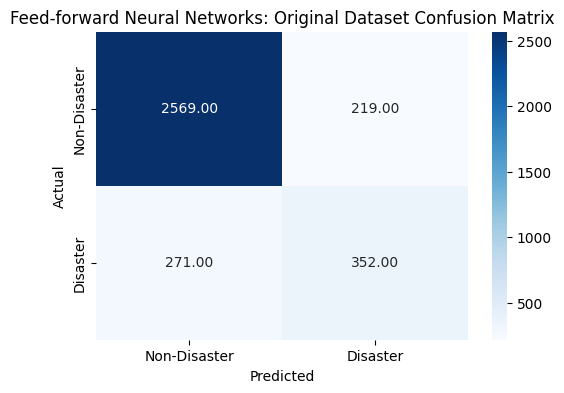

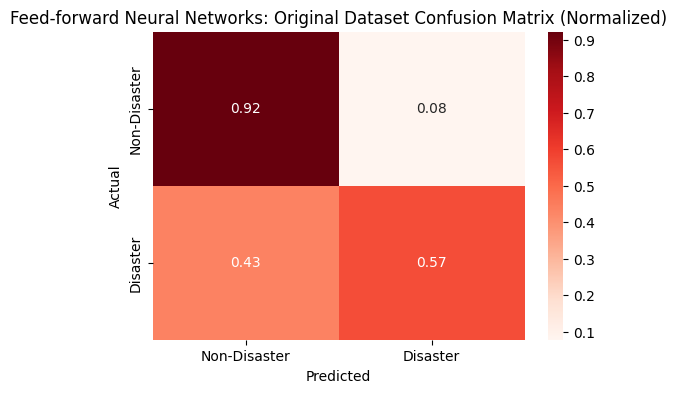

In [490]:
# Feed-foward Neural Networks on original dataset
ypred_ffnn = ffnn(X_train,y_train,X_test,y_test,index_embed,msq,embedding_size,"Original Dataset")
confusion(y_test, ypred_ffnn, 'Feed-forward Neural Networks: Original Dataset')

Epoch 1/10
11/11 [==============================] - 2s 26ms/step - loss: 0.6621 - accuracy: 0.5863
Epoch 2/10
11/11 [==============================] - 0s 27ms/step - loss: 0.5951 - accuracy: 0.6900
Epoch 3/10
11/11 [==============================] - 0s 23ms/step - loss: 0.5744 - accuracy: 0.6957
Epoch 4/10
11/11 [==============================] - 0s 23ms/step - loss: 0.5655 - accuracy: 0.7106
Epoch 5/10
11/11 [==============================] - 0s 21ms/step - loss: 0.5585 - accuracy: 0.7085
Epoch 6/10
11/11 [==============================] - 0s 22ms/step - loss: 0.5349 - accuracy: 0.7290
Epoch 7/10
11/11 [==============================] - 0s 23ms/step - loss: 0.5335 - accuracy: 0.7369
Epoch 8/10
11/11 [==============================] - 0s 25ms/step - loss: 0.5275 - accuracy: 0.7365
Epoch 9/10
11/11 [==============================] - 0s 23ms/step - loss: 0.5063 - accuracy: 0.7550
Epoch 10/10
11/11 [==============================] - 0s 24ms/step - loss: 0.4950 - accuracy: 0.7649
KerasTens

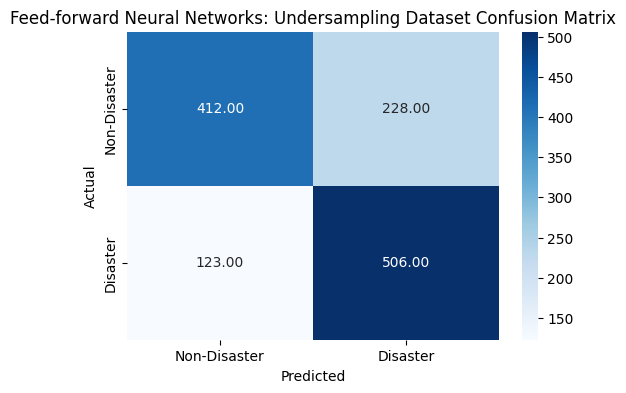

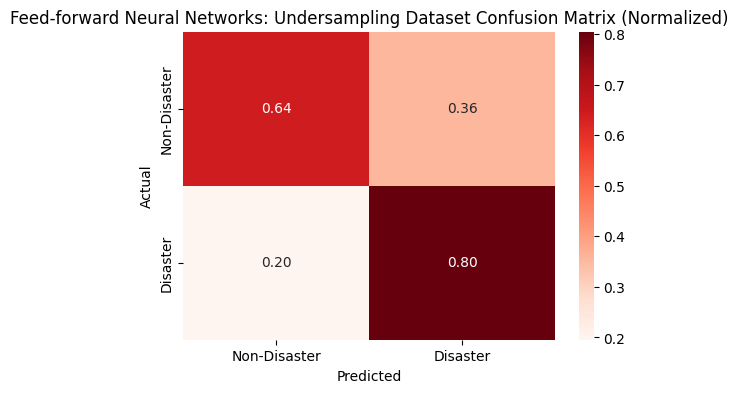

In [491]:
# Feed-foward Neural Networks on undersampling dataset
ypred_ffnn_undersampling = ffnn(X_train_undersampling,y_train_undersampling,X_test_undersampling,\
                  y_test_undersampling,index_embed_undersampling,msq_undersampling,\
                  embedding_size,"Undersampling Dataset")

confusion(y_test_undersampling, ypred_ffnn_undersampling, 'Feed-forward Neural Networks: Undersampling Dataset')

Epoch 1/10
50/50 [==============================] - 3s 28ms/step - loss: 0.4811 - accuracy: 0.7684
Epoch 2/10
50/50 [==============================] - 1s 25ms/step - loss: 0.2931 - accuracy: 0.8809
Epoch 3/10
50/50 [==============================] - 1s 25ms/step - loss: 0.1551 - accuracy: 0.9459
Epoch 4/10
50/50 [==============================] - 1s 25ms/step - loss: 0.0997 - accuracy: 0.9650
Epoch 5/10
50/50 [==============================] - 1s 25ms/step - loss: 0.0772 - accuracy: 0.9723
Epoch 6/10
50/50 [==============================] - 1s 28ms/step - loss: 0.0523 - accuracy: 0.9830
Epoch 7/10
50/50 [==============================] - 1s 25ms/step - loss: 0.0318 - accuracy: 0.9918
Epoch 8/10
50/50 [==============================] - 1s 26ms/step - loss: 0.0175 - accuracy: 0.9948
Epoch 9/10
50/50 [==============================] - 1s 25ms/step - loss: 0.0138 - accuracy: 0.9971
Epoch 10/10
50/50 [==============================] - 1s 25ms/step - loss: 0.0122 - accuracy: 0.9969
KerasTens

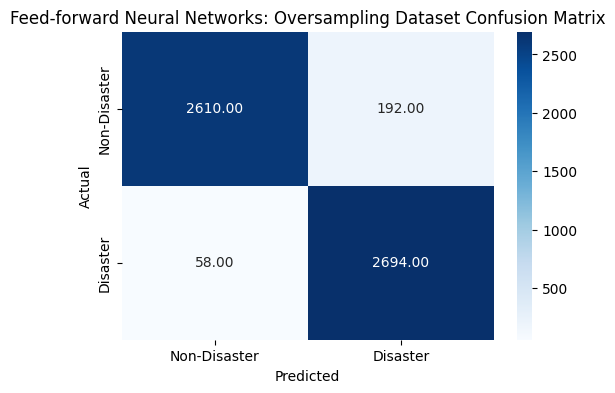

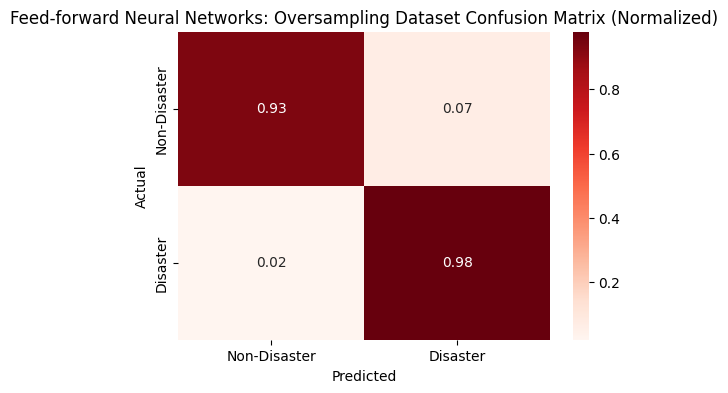

In [492]:
# Feed-foward Neural Networks on oversampling dataset
ypred_ffnn_oversampling = ffnn(X_train_oversampling,y_train_oversampling,X_test_oversampling,\
                  y_test_oversampling,index_embed_oversampling,msq_oversampling,\
                  embedding_size,"Oversampling Dataset")

confusion(y_test_oversampling, ypred_ffnn_oversampling, 'Feed-forward Neural Networks: Oversampling Dataset')

In [493]:
# Recurrent Neural Networks: LSTM
def lstm(X_train, y_train, X_test, y_test, index_embed, max_sequence_length, embedding_size, df_type):
  # hyperparameters
  epochs = 10
  batches = 256
  steps = len(X_train)//batches

  # Data generator
  train_generator = data_generator(X_train, y_train, batches, index_embed, "rnn")

  # Architecture
  model = Sequential()
  # LSTM input layer
  model.add(LSTM(512, input_shape=(max_sequence_length, embedding_size),return_sequences=True))
  # Dropout layer to prevent overfitting
  model.add(Dropout(0.2))
  model.add(LSTM(256, input_shape=(max_sequence_length, embedding_size),return_sequences=True))
  model.add(Dropout(0.2))
  # LSTM layer
  model.add(LSTM(128, input_shape=(max_sequence_length, embedding_size),return_sequences=True))
  model.add(LSTM(32))
  model.add(Dropout(0.2))
  # sigmoid for binary classification
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.fit(x= train_generator,
            steps_per_epoch= steps,
            epochs= epochs, verbose = 1)

  print(model.output)

  # save model
  joblib.dump(model, f"lstm_model_{df_type}.pk1")
  y_pred = model.predict(X_test)
  y_pred = [1 if output > 0.5 else 0 for output in y_pred]
  print('\nLSTM Neural Networks: ' + df_type + '\n')
  print('accuracy:', metrics.accuracy_score(y_test, y_pred))
  print(metrics.classification_report(y_test,y_pred))
  return y_pred

Epoch 1/10
31/31 [==============================] - 44s 813ms/step - loss: 0.4373 - accuracy: 0.8233
Epoch 2/10
31/31 [==============================] - 24s 782ms/step - loss: 0.3725 - accuracy: 0.8410
Epoch 3/10
31/31 [==============================] - 25s 799ms/step - loss: 0.3649 - accuracy: 0.8444
Epoch 4/10
31/31 [==============================] - 25s 792ms/step - loss: 0.3563 - accuracy: 0.8503
Epoch 5/10
31/31 [==============================] - 25s 796ms/step - loss: 0.3513 - accuracy: 0.8537
Epoch 6/10
31/31 [==============================] - 25s 799ms/step - loss: 0.3452 - accuracy: 0.8540
Epoch 7/10
31/31 [==============================] - 24s 787ms/step - loss: 0.3436 - accuracy: 0.8569
Epoch 8/10
31/31 [==============================] - 24s 788ms/step - loss: 0.3413 - accuracy: 0.8565
Epoch 9/10
31/31 [==============================] - 24s 777ms/step - loss: 0.3367 - accuracy: 0.8547
Epoch 10/10
31/31 [==============================] - 24s 784ms/step - loss: 0.3345 - accura

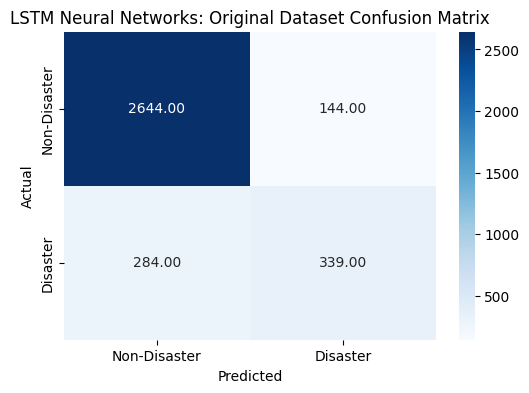

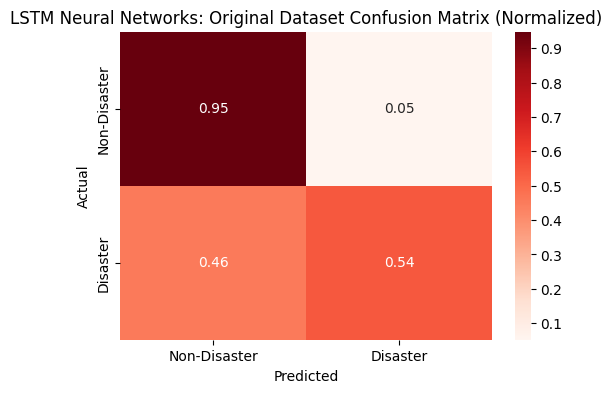

In [494]:
# LSTM Neural Networks on original dataset
ypred_lstm = lstm(X_train,y_train,X_test,y_test,index_embed,msq,embedding_size,"Original Dataset")
confusion(y_test, ypred_lstm, 'LSTM Neural Networks: Original Dataset')

Epoch 1/10
11/11 [==============================] - 20s 777ms/step - loss: 0.6594 - accuracy: 0.6154
Epoch 2/10
11/11 [==============================] - 8s 751ms/step - loss: 0.5957 - accuracy: 0.7010
Epoch 3/10
11/11 [==============================] - 8s 750ms/step - loss: 0.5908 - accuracy: 0.6889
Epoch 4/10
11/11 [==============================] - 8s 742ms/step - loss: 0.5664 - accuracy: 0.7180
Epoch 5/10
11/11 [==============================] - 8s 751ms/step - loss: 0.5531 - accuracy: 0.7209
Epoch 6/10
11/11 [==============================] - 9s 819ms/step - loss: 0.5394 - accuracy: 0.7333
Epoch 7/10
11/11 [==============================] - 9s 782ms/step - loss: 0.5546 - accuracy: 0.7276
Epoch 8/10
11/11 [==============================] - 9s 782ms/step - loss: 0.5505 - accuracy: 0.7251
Epoch 9/10
11/11 [==============================] - 8s 770ms/step - loss: 0.5232 - accuracy: 0.7422
Epoch 10/10
11/11 [==============================] - 9s 773ms/step - loss: 0.5093 - accuracy: 0.754

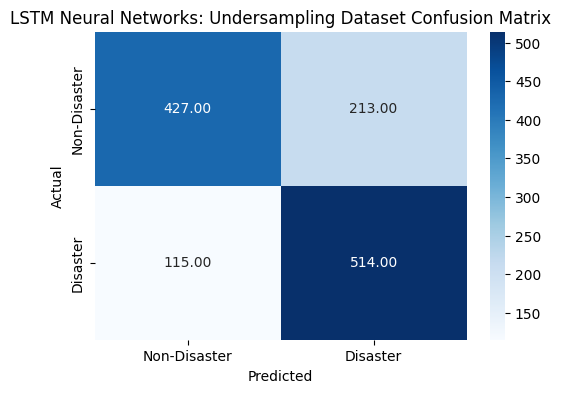

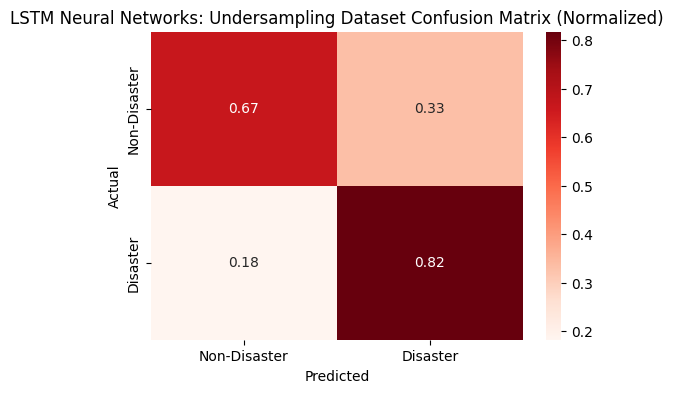

In [495]:
# LSTM Neural Networks on undersampling dataset
ypred_lstm_undersampling = lstm(X_train_undersampling,y_train_undersampling,X_test_undersampling,\
                  y_test_undersampling,index_embed_undersampling,msq_undersampling,\
                  embedding_size,"Undersampling Dataset")

confusion(y_test_undersampling, ypred_lstm_undersampling, 'LSTM Neural Networks: Undersampling Dataset')

Epoch 1/10
50/50 [==============================] - 51s 777ms/step - loss: 0.5042 - accuracy: 0.7602
Epoch 2/10
50/50 [==============================] - 37s 739ms/step - loss: 0.4157 - accuracy: 0.8188
Epoch 3/10
50/50 [==============================] - 37s 745ms/step - loss: 0.3642 - accuracy: 0.8462
Epoch 4/10
50/50 [==============================] - 33s 665ms/step - loss: 0.3341 - accuracy: 0.8605
Epoch 5/10
50/50 [==============================] - 30s 605ms/step - loss: 0.3056 - accuracy: 0.8755
Epoch 6/10
50/50 [==============================] - 35s 710ms/step - loss: 0.2730 - accuracy: 0.8901
Epoch 7/10
50/50 [==============================] - 36s 711ms/step - loss: 0.2451 - accuracy: 0.9048
Epoch 8/10
50/50 [==============================] - 35s 699ms/step - loss: 0.2311 - accuracy: 0.9093
Epoch 9/10
50/50 [==============================] - 37s 733ms/step - loss: 0.2085 - accuracy: 0.9180
Epoch 10/10
50/50 [==============================] - 35s 704ms/step - loss: 0.1899 - accura

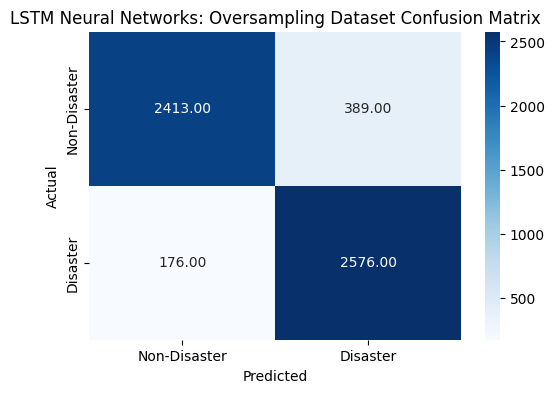

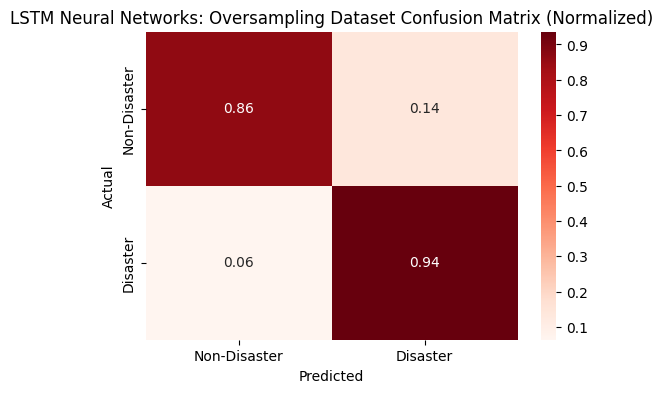

In [496]:
# Feed-foward Neural Networks on oversampling dataset
ypred_lstm_oversampling = lstm(X_train_oversampling,y_train_oversampling,X_test_oversampling,\
                  y_test_oversampling,index_embed_oversampling,msq_oversampling,\
                  embedding_size,"Oversampling Dataset")

confusion(y_test_oversampling, ypred_lstm_oversampling, 'LSTM Neural Networks: Oversampling Dataset')

In [497]:
# Recurrent Neural Networks : Bidirectional LSTM
def bilstm(X_train, y_train, X_test, y_test, index_embed, max_sequence_length, embedding_size, df_type):
  # hyperparameters
  epochs = 5
  batches = 256
  steps = len(X_train)//batches

  # Data generator
  train_generator = data_generator(X_train, y_train, batches, index_embed, "rnn")

  # Model architecture
  model = Sequential()
  # LSTM input layer
  model.add(LSTM(512, input_shape=(max_sequence_length, embedding_size),return_sequences=True))
  model.add(LSTM(256, input_shape=(max_sequence_length, embedding_size),return_sequences=True))
  # Dropout layer to prevent overfitting
  model.add(Dropout(0.2))
  # Bidirectional LSTM layer for extra context
  model.add(Bidirectional(LSTM(128)))
  model.add(Dropout(0.2))
  # sigmoid for binary classification
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.fit(x= train_generator,
            steps_per_epoch= steps,
            epochs= epochs, verbose = 1)

  print(model.output)

  # save model
  joblib.dump(model, f"bidirectional_lstm_model_{df_type}.pk1")
  y_pred = model.predict(X_test)
  y_pred = [1 if output > 0.5 else 0 for output in y_pred]
  print('\nBidirectional Neural Network: ' + df_type + '\n')
  print('accuracy:', metrics.accuracy_score(y_test, y_pred))
  print(metrics.classification_report(y_test,y_pred))
  return y_pred

Epoch 1/5
31/31 [==============================] - 26s 616ms/step - loss: 0.4329 - accuracy: 0.8129
Epoch 2/5
31/31 [==============================] - 21s 693ms/step - loss: 0.3746 - accuracy: 0.8420
Epoch 3/5
31/31 [==============================] - 22s 703ms/step - loss: 0.3637 - accuracy: 0.8460
Epoch 4/5
31/31 [==============================] - 22s 724ms/step - loss: 0.3541 - accuracy: 0.8489
Epoch 5/5
31/31 [==============================] - 23s 736ms/step - loss: 0.3494 - accuracy: 0.8542
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_159/Sigmoid:0', description="created by layer 'dense_159'")
107/107 [==============================] - 9s 66ms/step

Bidirectional Neural Network: Original Dataset

accuracy: 0.8648490178833187
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2788
           1       0.67      0.52      0.58       623

    accuracy                           0.86      3

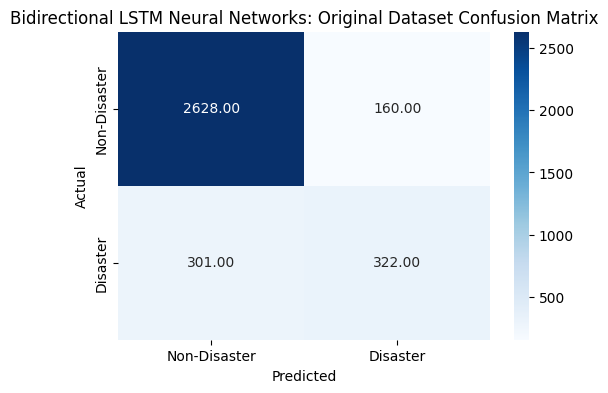

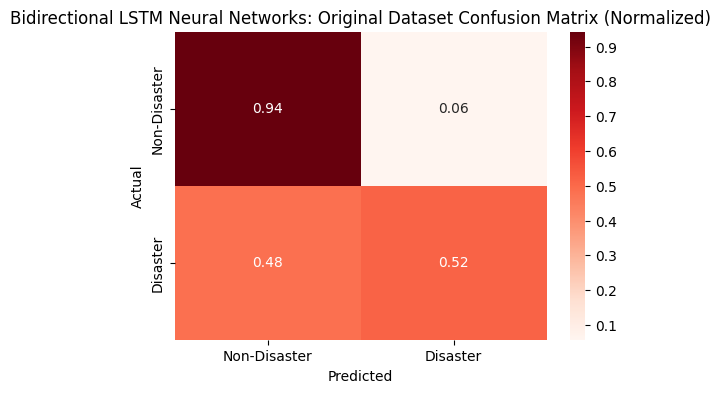

In [498]:
# Bidirectional LSTM Neural Networks on original dataset
ypred_bilstm = bilstm(X_train,y_train,X_test,y_test,index_embed,msq,embedding_size,"Original Dataset")
confusion(y_test, ypred_bilstm, 'Bidirectional LSTM Neural Networks: Original Dataset')

Epoch 1/5
11/11 [==============================] - 13s 582ms/step - loss: 0.6935 - accuracy: 0.5153
Epoch 2/5
11/11 [==============================] - 8s 747ms/step - loss: 0.6327 - accuracy: 0.6712
Epoch 3/5
11/11 [==============================] - 8s 766ms/step - loss: 0.5791 - accuracy: 0.7109
Epoch 4/5
11/11 [==============================] - 9s 809ms/step - loss: 0.5636 - accuracy: 0.7156
Epoch 5/5
11/11 [==============================] - 11s 1s/step - loss: 0.5435 - accuracy: 0.7312
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_160/Sigmoid:0', description="created by layer 'dense_160'")
40/40 [==============================] - 6s 71ms/step

Bidirectional Neural Network: Undersampling Dataset

accuracy: 0.727344365642238
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       640
           1       0.76      0.66      0.71       629

    accuracy                           0.73      1269


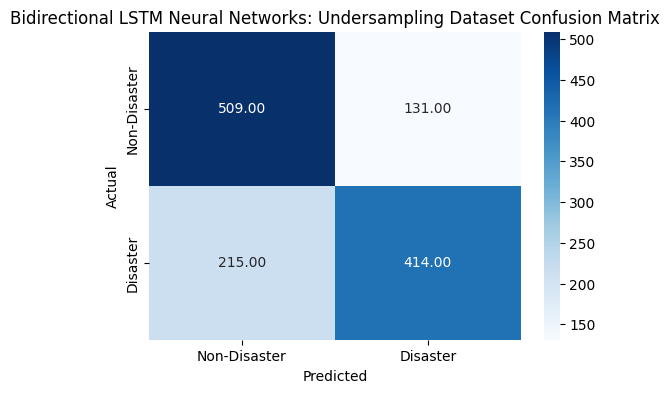

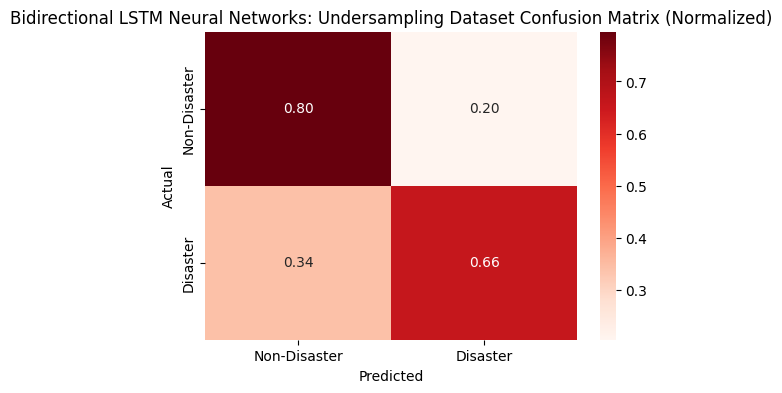

In [499]:
# Bidirectional LSTM Neural Networks on undersampling dataset
ypred_bilstm_undersampling = bilstm(X_train_undersampling,y_train_undersampling,X_test_undersampling,\
                  y_test_undersampling,index_embed_undersampling,msq_undersampling,\
                  embedding_size,"Undersampling Dataset")

confusion(y_test_undersampling, ypred_bilstm_undersampling, 'Bidirectional LSTM Neural Networks: Undersampling Dataset')

Epoch 1/5
50/50 [==============================] - 61s 975ms/step - loss: 0.4891 - accuracy: 0.7675
Epoch 2/5
50/50 [==============================] - 42s 838ms/step - loss: 0.3972 - accuracy: 0.8296
Epoch 3/5
50/50 [==============================] - 36s 726ms/step - loss: 0.3551 - accuracy: 0.8482
Epoch 4/5
50/50 [==============================] - 37s 743ms/step - loss: 0.3125 - accuracy: 0.8697
Epoch 5/5
50/50 [==============================] - 40s 807ms/step - loss: 0.2882 - accuracy: 0.8834
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_161/Sigmoid:0', description="created by layer 'dense_161'")
174/174 [==============================] - 14s 73ms/step

Bidirectional Neural Network: Oversampling Dataset

accuracy: 0.87900612171408
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2802
           1       0.86      0.90      0.88      2752

    accuracy                           0.88    

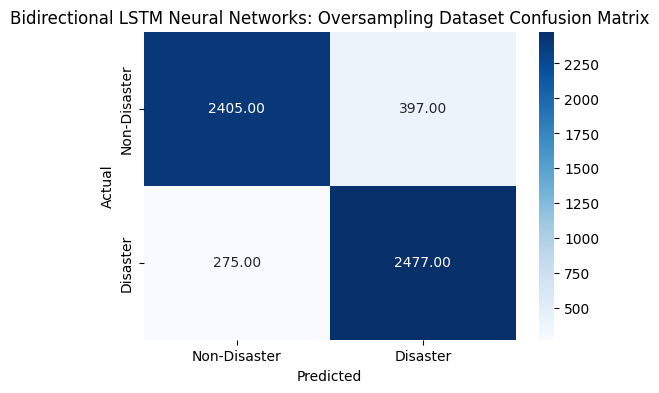

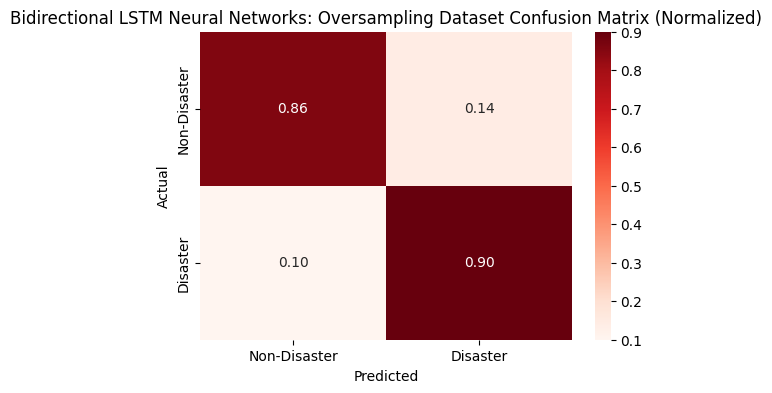

In [500]:
# Bidirectional LSTM Neural Networks on oversampling dataset
ypred_bilstm_oversampling = bilstm(X_train_oversampling,y_train_oversampling,X_test_oversampling,\
                  y_test_oversampling,index_embed_oversampling,msq_oversampling,\
                  embedding_size,"Oversampling Dataset")

confusion(y_test_oversampling, ypred_bilstm_oversampling, 'Bidirectional LSTM Neural Networks: Oversampling Dataset')